# Poincare Boundary Condition

Most of the tutorials use last closed flux surface (LCFS) as the boundary condition for 3D equilibrium. This tutorial will cover another way to define boundary condition using DESC.

In [4]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines. 

In [5]:
from desc import set_device

set_device("gpu")

/CODES/DESC/desc/__init__.py:114: UserWarning: CUDA_VISIBLE_DEVICES= did not match any physical GPU (id=['0']), falling back to CPU
  warnings.warn(


In [6]:
%matplotlib inline
import numpy as np

from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    get_fixed_xsection_constraints,
    get_fixed_boundary_constraints,
)
from desc.examples import get
from desc.plotting import *
from desc.geometry import ZernikeRZToroidalSection
from desc.equilibrium import Equilibrium

DESC version 0.13.0+1563.ge45365e79.dirty,using JAX backend, jax version=0.4.38, jaxlib version=0.4.38, dtype=float64
Using device: CPU, with 9.73 GB available memory


### Solving Poincare Boundary Condition from an existing equilibrium

To first show that Poincare BC gives the same result with LCFS, let's set our optimization problem by taking the $\zeta$=0 Poincare cross-section of Heliotron equilibrium.

In [7]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [8]:
eq = get("HELIOTRON")

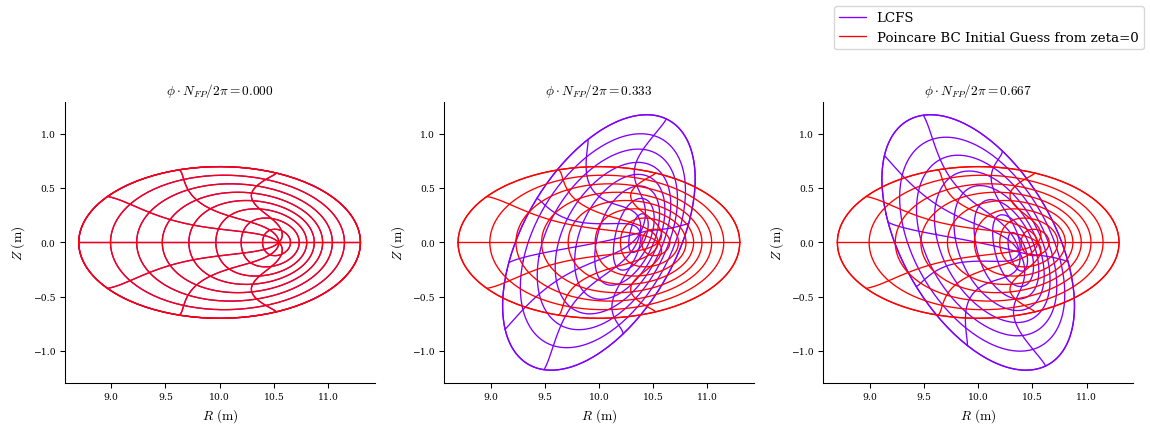

In [9]:
eq_poin = set_poincare_equilibrium(eq)
plot_comparison(
    eqs=[eq, eq_poin], phi=3, labels=["LCFS", f"Poincare BC Initial Guess from zeta=0"]
);

Now, we can solve the newly created `eq_poin` as usual. The code will apply some checks to see if you are trying to solve a Poincare BC problem or LCFS. Then, add the required constraints and objectives before sending it to the optimizer.

In [10]:
eq_poin = set_poincare_equilibrium(eq)  # zeta=0 surface will be fixed
for N in range(1, eq.N + 1):
    eq_poin.change_resolution(N=N, N_grid=2 * N)

    constraints = get_fixed_xsection_constraints(eq=eq_poin)
    objective = ObjectiveFunction(ForceBalance(eq_poin))

    eq_poin.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=50,
    );

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 347 ms
Timer: Objective build = 665 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 524 ms
Timer: Linear constraint projection build = 3.80 sec
Number of parameters: 507
Number of objectives: 1900
Timer: Initializing the optimization = 5.02 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1       

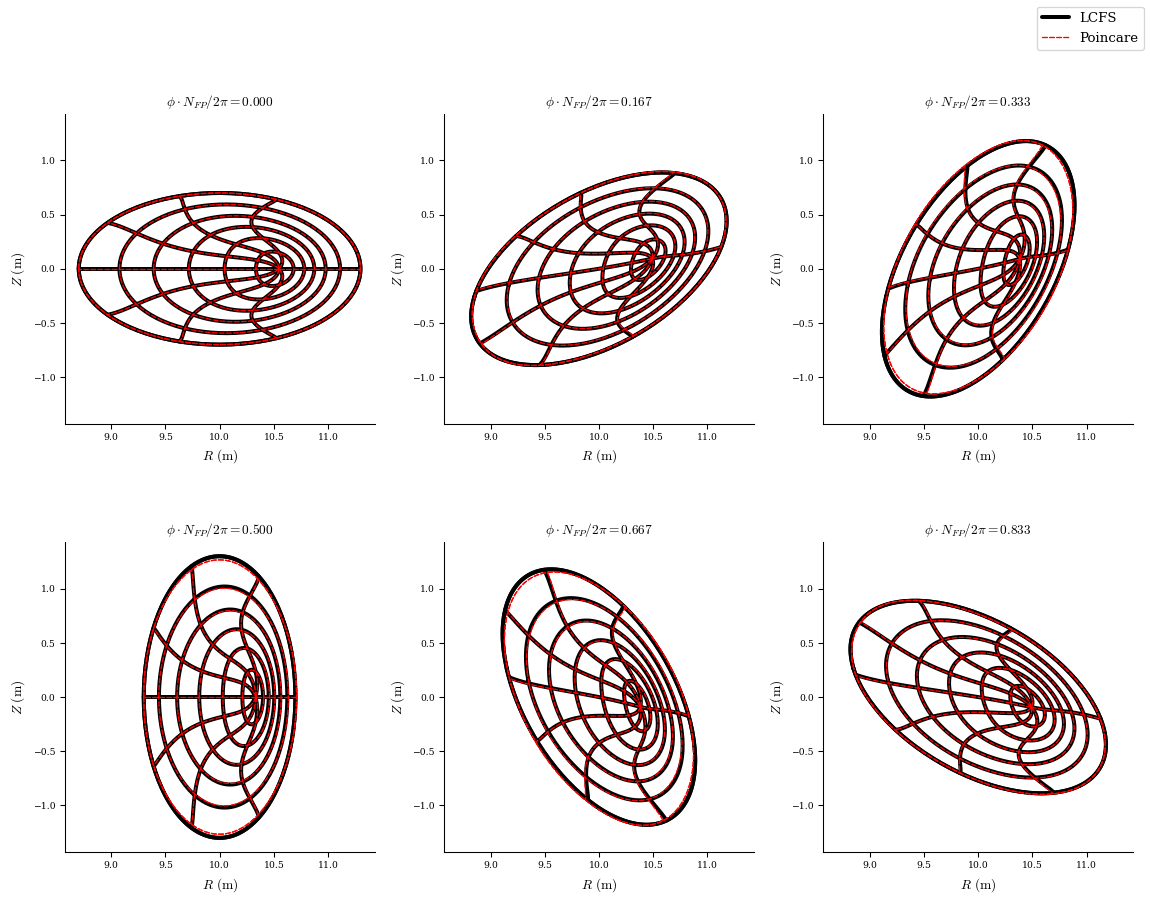

In [11]:
plot_comparison(
    eqs=[eq, eq_poin],
    rho=6,
    labels=["LCFS", "Poincare"],
    ls=["-", "--"],
    lw=[3, 1],
    color=["k", "r"],
);

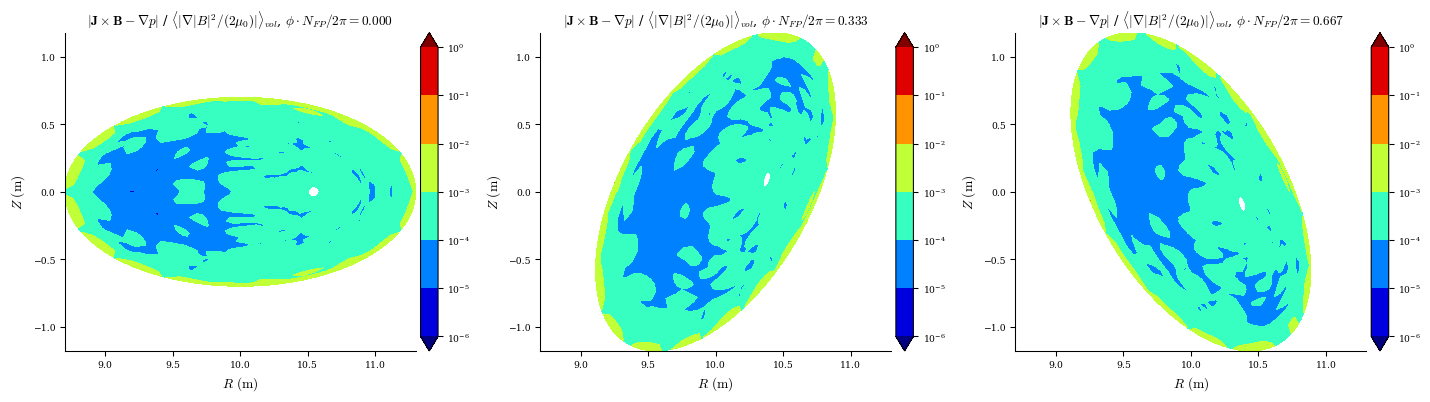

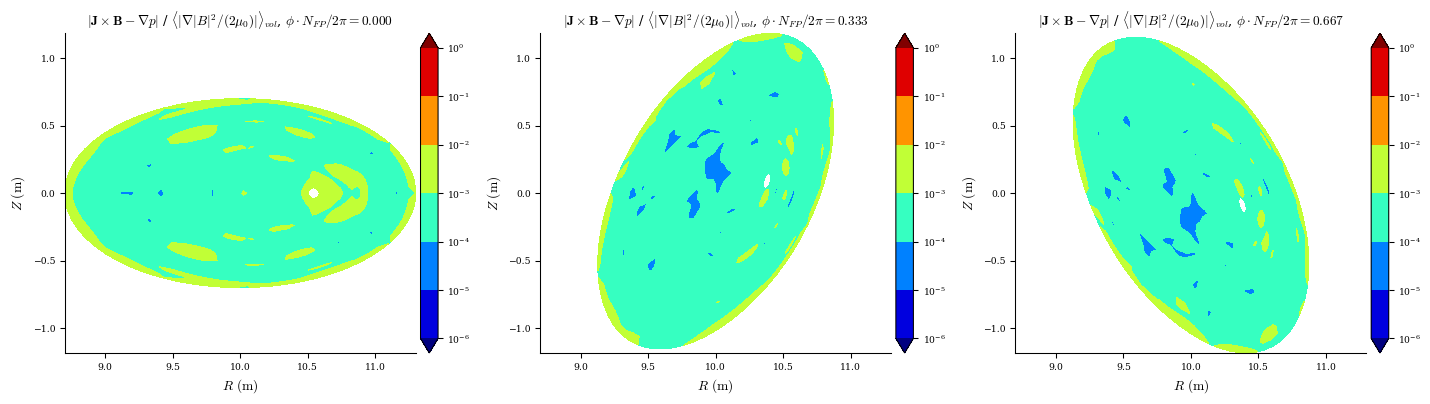

In [12]:
plot_section(eq, "|F|", phi=3, norm_F=True, log=True)
plot_section(eq_poin, "|F|", phi=3, norm_F=True, log=True);

We can see that especially around the last closed flux surface, the final equilibrium obtained by Poincare boundary condition has lower force error. This property can be used to reduce the force balance error of an existing equilibrium. Below, it can be seen that the volume averaged normalized force error is also lower for `eq_poin`.

In [13]:
f1 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq_poin.compute("<|F|>_vol")["<|F|>_vol"]
    / eq_poin.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq_lcfs: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

Force error eq_lcfs: 3.0407e-04
Force error eq_poin: 4.7791e-04


### Creating a new Poincare surface to fix 

We can also create a new surface object called "ZernikeRZToroidalSection" to set our optimization problem as LCFS.

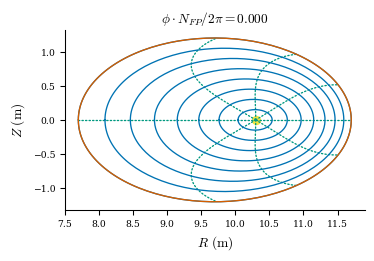

In [117]:
R_lmn = np.array([10, -2, -0.3])
modes_R = np.array([[0, 0], [1, 1], [2, 0]])

Z_lmn = np.array([1.2])
modes_Z = np.array([[1, -1]])

L_lmn = np.array([-0.6, -0.2])
modes_L = np.array([[1, -1], [3, -1]])

section = ZernikeRZToroidalSection(
    R_lmn=R_lmn,
    modes_R=modes_R,
    Z_lmn=Z_lmn,
    modes_Z=modes_Z,
    L_lmn=L_lmn,
    modes_L=modes_L,
)

eq_poincare = Equilibrium(
    xsection=section,
    Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
    pressure=0,
    iota=0,
    NFP=10,  # number of field periods
    L=5,  # radial spectral resolution
    M=5,  # poloidal spectral resolution
    N=3,  # toroidal spectral resolution
    L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
    M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
    N_grid=eq.N_grid,  # real space toroidal resolution
    sym=True,  # explicitly enforce stellarator symmetry
    spectral_indexing=eq._spectral_indexing,
)

plot_surfaces(eq_poincare, phi=1);

## Using Poincare Boundary Condition to reduce Force Error around the LCFS

As we mentioned above, the equilibrium solved by Poincare boundary condition has lower force error around the LCFS. We can use this procedure to relax the last closed flux surface parameters, and obtain a better equilibrium close to the original equilibrium.

Let's use W7-X example.

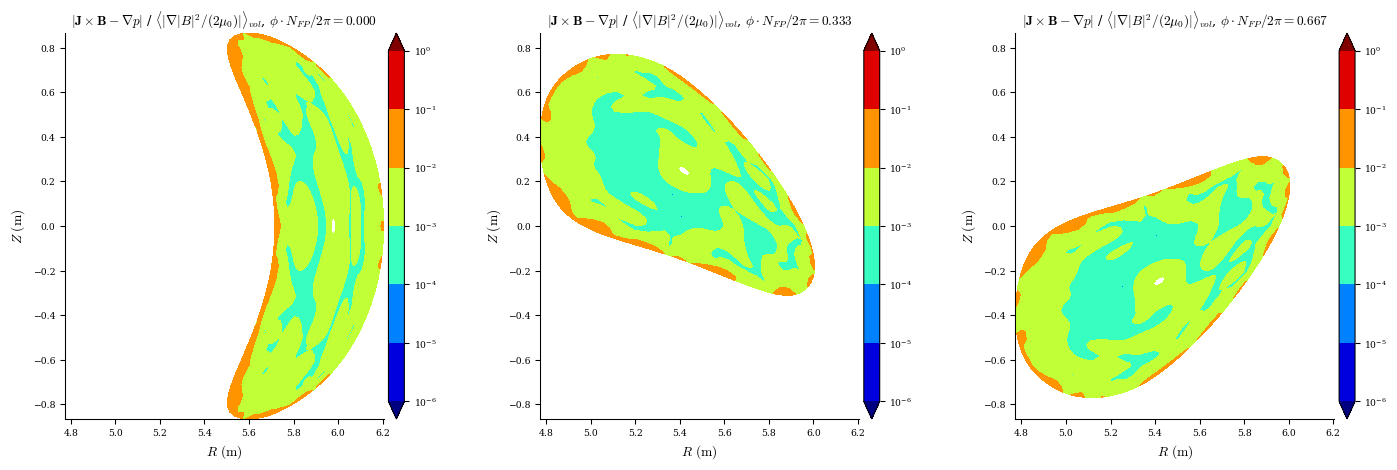

In [11]:
eq0 = get("W7-X")
plot_section(eq0, "|F|", phi=3, norm_F=True, log=True);

This time, we will use the `get_fixed_xsection_constraints` function with `fix_lambda=False`. We can also use the default `fix_lambda=True` but by not fixing the lambda, we add an additional freedom to improve the force balance at the fixed cross-section, too. We didn't use this approach above to save time, since more optimizable parameters increase the size of the Jacobian and makes every computation slower. Our initial equilibrium is already in a good force balance, therefore the new solve won't take too long, and we accept slower iterations.

In [12]:
eq = eq0.copy()
constraints = get_fixed_xsection_constraints(eq=eq, fix_lambda=False)
objective = ObjectiveFunction(ForceBalance(eq))

eq.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=50,
);

Building objective: force
Precomputing transforms


Timer: Precomputing transforms = 251 ms
Timer: Objective build = 420 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: fixed cross-section λ
Timer: Objective build = 365 ms
Timer: Linear constraint projection build = 5.00 sec
Number of parameters: 3318
Number of objectives: 5346
Timer: Initializing the optimization = 6.23 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.653e-07                                    4.385e-05   
       1              5          5.

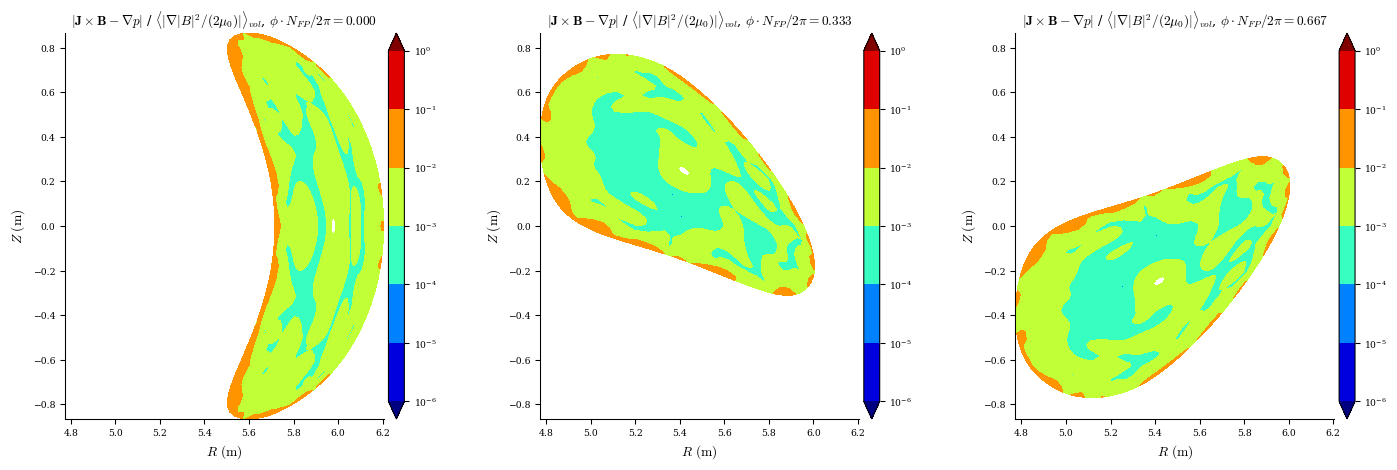

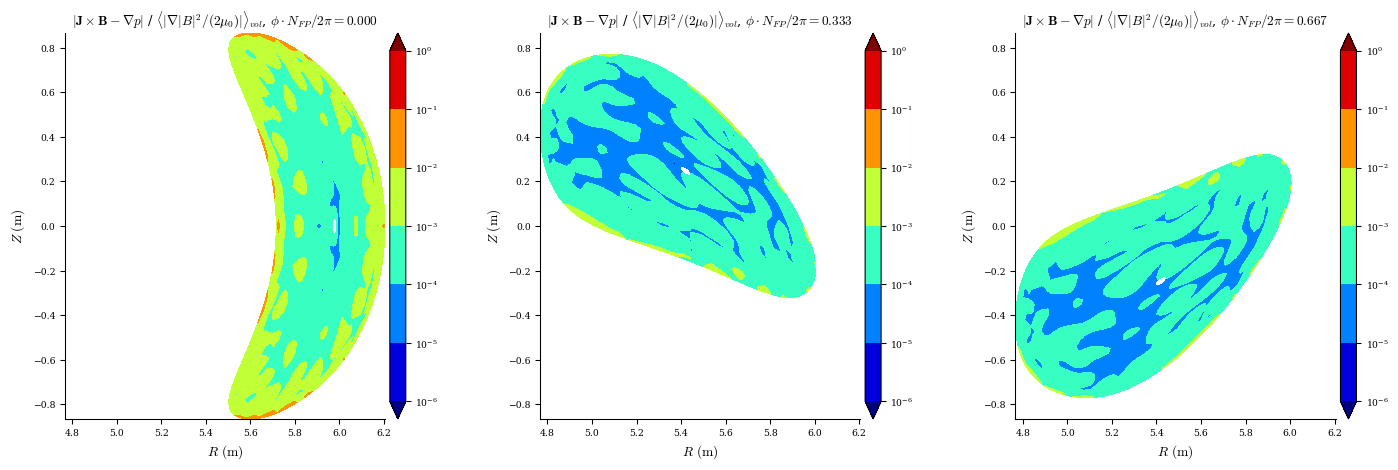

In [13]:
plot_section(eq0, "|F|", phi=3, norm_F=True, log=True)
plot_section(eq, "|F|", phi=3, norm_F=True, log=True);

In [14]:
f1 = (
    eq0.compute("<|F|>_vol")["<|F|>_vol"]
    / eq0.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq_lcfs: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

Force error eq_lcfs: 2.8639e-03
Force error eq_poin: 2.9127e-04


As expected, we got a much better force equilibrium. And as it can be seen from the next figure, this is achieved by minor changes to the last closed flux surface shape.

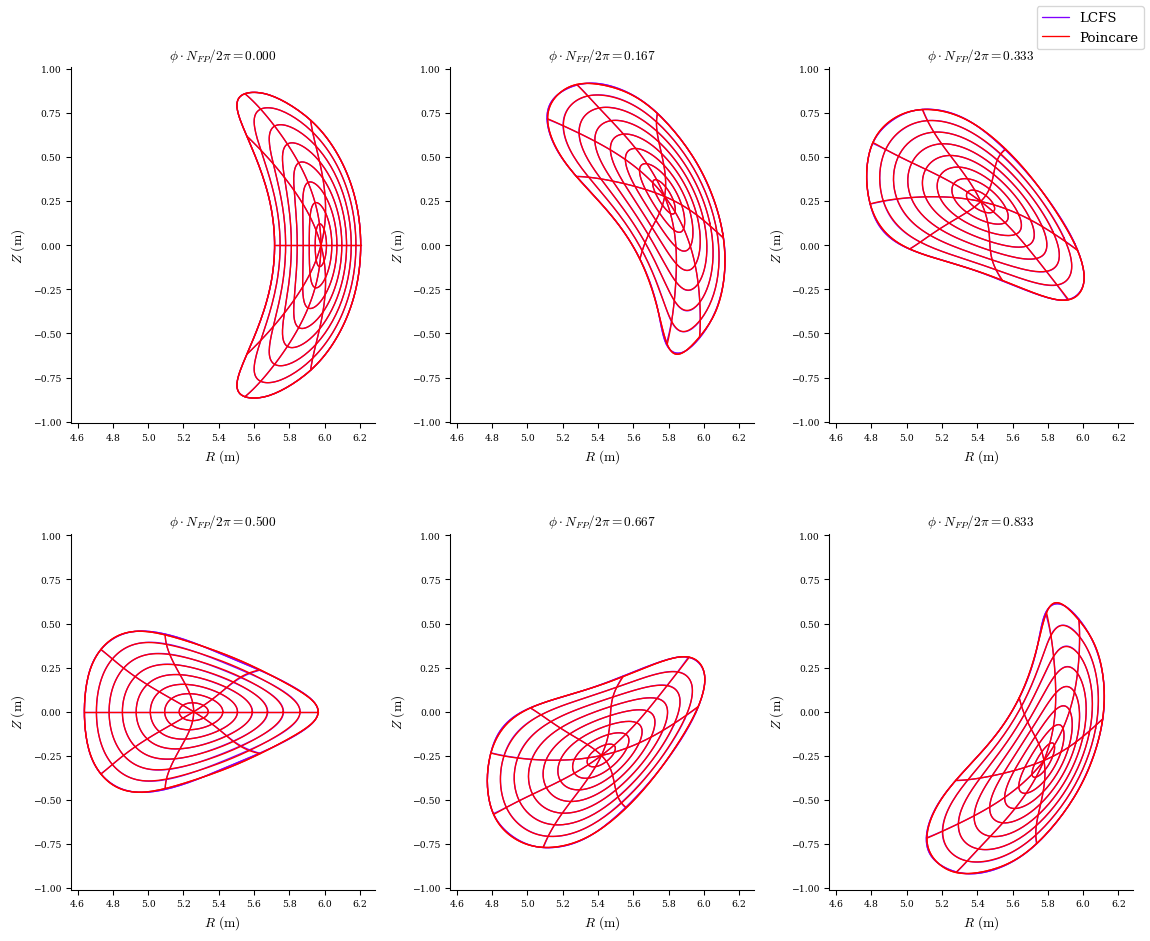

In [136]:
plot_comparison(eqs=[eq0, eq], labels=["LCFS", "Poincare"]);

One can use the reverse strategy to improve the force balance error of the final equilibrium around the fixed cross-section, and get a much better equilibrium otherwise very hard to get (even with extermely small stopping tolerances for the optimizer).